<a href="https://colab.research.google.com/github/keran-w/Projects-in-ML-and-AI/blob/main/ProjML%26AI_hw4_task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from matplotlib import pyplot as plt

import torch
from torch import nn
from tqdm import tqdm

from sklearn.model_selection import train_test_split

plt.style.use('seaborn')
torch.manual_seed(0);

In [3]:
# download dataset
# data source: https://archive.ics.uci.edu/ml/datasets/Indoor+User+Movement+Prediction+from+RSS+data
from IPython import display
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00348/MovementAAL.zip
!unzip MovementAAL.zip
display.clear_outpuNt()

In [8]:
# read datasets
data_list = [pd.read_csv(f'dataset/MovementAAL_RSS_{i}.csv') for i in range(1, 315)]
target = pd.read_csv('dataset/MovementAAL_target.csv')[' class_label']

In [12]:
# data preprocessing
print(data_list[0].shape, data_list[1].shape, data_list[2].shape)
data_list[0].head()

(27, 4) (26, 4) (23, 4)


,#RSS_anchor1,RSS_anchor2,RSS_anchor3,RSS_anchor4
0,-0.90476,-0.48,0.28571,0.30
1,-0.57143,-0.32,0.14286,0.30
2,-0.38095,-0.28,-0.14286,0.35
3,-0.28571,-0.20,-0.47619,0.35
4,-0.14286,-0.20,0.14286,-0.20


In [19]:
# we notice that each time series data does not have the exactly same length
# so next we will decide the sequence length for this time series data
import numpy as np
seq_len_series = pd.Series([data.shape[0] for data in data_list])
seq_len_series.describe()

# we will use 56 for our sequence length, which could include 75% of data
seq_len = 56

In [20]:
# Next, we will pad any sequence less than 56 in length and 
# truncate any sequence with a greater-than-56 length
X = np.array([data.reindex(range(seq_len)).fillna(0).values for data in data_list])
y = np.where(target.values == -1, 0, 1)

In [21]:
# split train, valid, test set
train_id, test_id = train_test_split(np.arange(X.shape[0]), test_size=0.1, random_state=20)
train_id, valid_id = train_test_split(train_id, test_size=0.11, random_state=20)
print(len(train_id), len(valid_id), len(test_id))
X_train, y_train = X[train_id], y[train_id]
X_valid, y_valid = X[valid_id], y[valid_id]
X_test, y_test = X[test_id], y[test_id]

250 32 32


In [22]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def get_loader(X, y, shuffle=False, batch_size=32):
    return torch.utils.data.DataLoader(Dataset(X, y), shuffle=shuffle, batch_size=batch_size)

train_loader = get_loader(X_train, y_train, shuffle=True)
valid_loader = get_loader(X_valid, y_valid)
test_loader = get_loader(X_test, y_test)
sample_batch = next(iter(train_loader))
sample_X, sample_y = sample_batch

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class RNNClassifier(nn.Module):
    
    def __init__(self, model_name, input_size, hidden_size, num_layers, num_classes):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.output = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        logits = self.lstm(x, (h0, c0))[0][:, -1, :] # use the last hidden layer as output
        logits = self.output(logits)
        return logits

input_size = X.shape[2]
hidden_size = 32
num_layers = 3
num_classes = len(set(y))

model = RNNClassifier('rnn', input_size, hidden_size, num_layers, num_classes).to(device)
model(sample_batch[0].to(device)).shape

torch.Size([32, 2])

rnn [  1 | 500] train_loss=0.695 valid_accuracy=0.562 valid_f1_score=0.720
rnn [100 | 500] train_loss=0.108 valid_accuracy=0.781 valid_f1_score=0.774
rnn [200 | 500] train_loss=0.142 valid_accuracy=0.938 valid_f1_score=0.941
rnn [300 | 500] train_loss=0.001 valid_accuracy=0.969 valid_f1_score=0.971
rnn [400 | 500] train_loss=0.001 valid_accuracy=0.969 valid_f1_score=0.971
rnn [500 | 500] train_loss=0.000 valid_accuracy=0.969 valid_f1_score=0.971

 rnn Test set evaluation
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        19
           1       0.92      0.85      0.88        13

    accuracy                           0.91        32
   macro avg       0.91      0.90      0.90        32
weighted avg       0.91      0.91      0.91        32



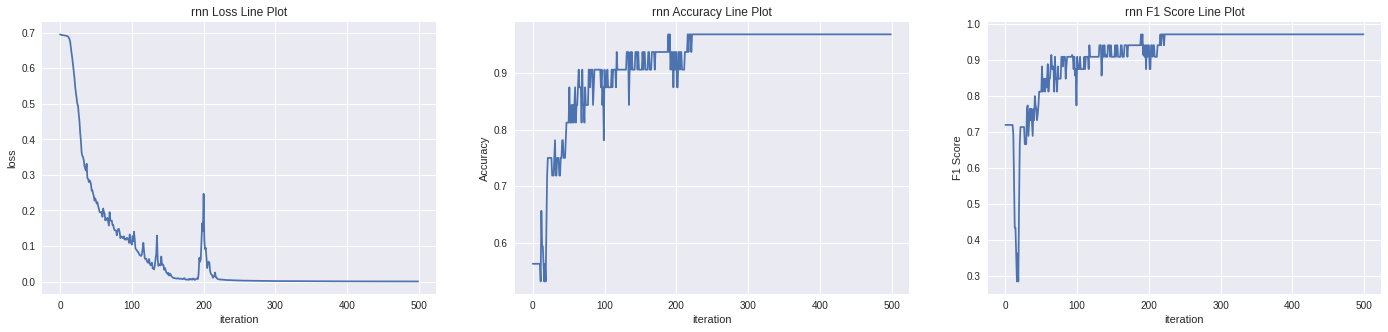


lstm [  1 | 500] train_loss=0.693 valid_accuracy=0.562 valid_f1_score=0.720
lstm [100 | 500] train_loss=0.530 valid_accuracy=0.719 valid_f1_score=0.667
lstm [200 | 500] train_loss=0.242 valid_accuracy=0.750 valid_f1_score=0.733
lstm [300 | 500] train_loss=0.122 valid_accuracy=0.844 valid_f1_score=0.839
lstm [400 | 500] train_loss=0.071 valid_accuracy=0.875 valid_f1_score=0.882
lstm [500 | 500] train_loss=0.043 valid_accuracy=0.875 valid_f1_score=0.882

 lstm Test set evaluation
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.92      0.96        13

    accuracy                           0.97        32
   macro avg       0.97      0.96      0.97        32
weighted avg       0.97      0.97      0.97        32



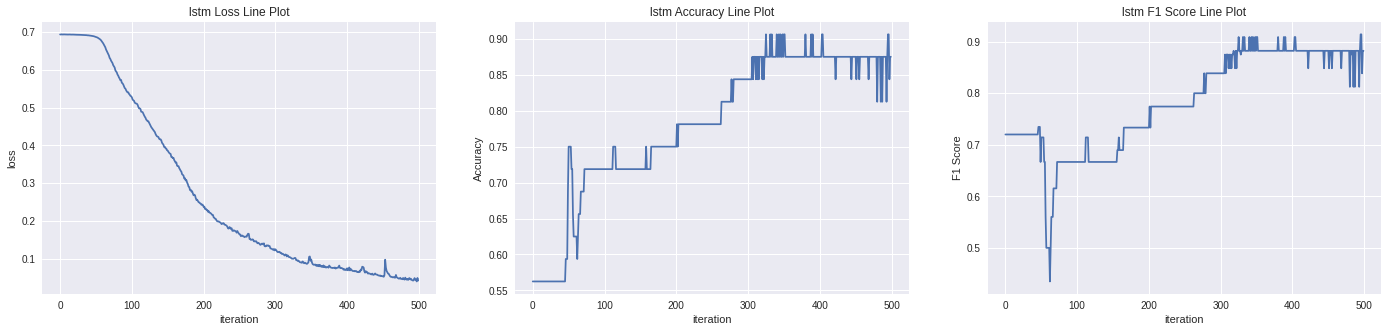


gru [  1 | 500] train_loss=0.706 valid_accuracy=0.438 valid_f1_score=0.000
gru [100 | 500] train_loss=0.332 valid_accuracy=0.719 valid_f1_score=0.727
gru [200 | 500] train_loss=0.106 valid_accuracy=0.938 valid_f1_score=0.941
gru [300 | 500] train_loss=0.058 valid_accuracy=0.906 valid_f1_score=0.909
gru [400 | 500] train_loss=0.045 valid_accuracy=0.906 valid_f1_score=0.909
gru [500 | 500] train_loss=0.009 valid_accuracy=0.969 valid_f1_score=0.971

 gru Test set evaluation
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.92      0.96        13

    accuracy                           0.97        32
   macro avg       0.97      0.96      0.97        32
weighted avg       0.97      0.97      0.97        32



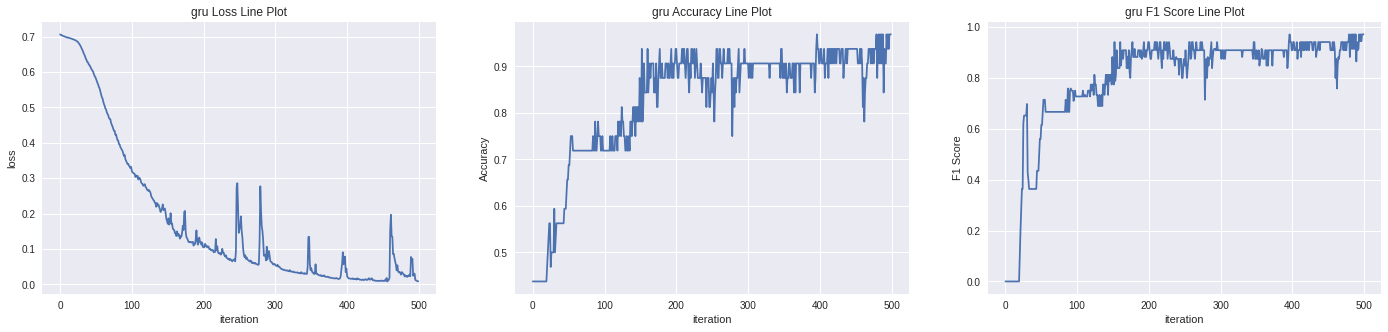

In [27]:
def train_step(model, train_loader, criterion, optimizer, device):
    model.train()
    loss_lst = []
    for X, y in train_loader:
        X = X.squeeze().reshape(-1, seq_len, input_size).to(device)
        y = y.to(device)
        logits = model(X)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_lst.append(loss.item())
    
    return loss_lst
    

def valid_step(model, test_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    for X, y in test_loader:
        X = X.squeeze().reshape(-1, seq_len, input_size).to(device)
        logits = model(X)
        predictions += logits.argmax(1).tolist()
        true_labels += y.tolist()
    
    return true_labels, predictions

def runner(model_name, num_epochs, learning_rate):
    model = RNNClassifier(model_name, input_size, hidden_size, num_layers, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

    metrics_list = []
    for epoch in range(num_epochs):
        loss_lst = train_step(model, train_loader, criterion, optimizer, device)
        y_true, y_pred = valid_step(model, valid_loader, device)
        train_loss = np.mean(loss_lst)
        valid_accuracy = metrics.accuracy_score(y_true, y_pred)
        valid_f1_score = metrics.f1_score(y_true, y_pred)
        metrics_list.append([train_loss, valid_accuracy, valid_f1_score])
        if epoch % 100 == 99 or epoch == num_epochs - 1 or epoch == 0:
            print(f'{model_name} [{epoch+1:3d} | {num_epochs}] train_loss={train_loss:.3f} valid_accuracy={valid_accuracy:.3f} valid_f1_score={valid_f1_score:.3f}')
    
    # test set evaluation
    y_true, y_pred = valid_step(model, test_loader, device)
    print(f'\n {model_name} Test set evaluation')
    print(metrics.classification_report(y_true, y_pred))
    metrics_list = np.array(metrics_list)
    fig, ax = plt.subplots(1,3, figsize=(24, 5))
    ax[0].plot(metrics_list[:, 0])
    ax[0].set_xlabel('iteration')
    ax[0].set_ylabel('loss')
    ax[0].set_title(f'{model_name} Loss Line Plot')

    metrics_list = np.array(metrics_list)
    ax[1].plot(metrics_list[:, 1])
    ax[1].set_xlabel('iteration')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title(f'{model_name} Accuracy Line Plot')

    metrics_list = np.array(metrics_list)
    ax[2].plot(metrics_list[:, 2])
    ax[2].set_xlabel('iteration')
    ax[2].set_ylabel('F1 Score')
    ax[2].set_title(f'{model_name} F1 Score Line Plot')
    plt.show()

num_epochs = 500
model_names = ('rnn', 'lstm', 'gru')
learning_rates = (3e-4, 5e-5, 1e-4)
for model_name, learning_rate in zip(model_names, learning_rates):
    runner(model_name, num_epochs, learning_rate)
    print()

### Part 3 (10 points)

Can you use the traditional feed-forward network to solve the same problem. Why or why not? (Hint: Can time series data be converted to usual features that can be used as input to a feed-forward network?)

In [ ]:
X_train[0][:5]

array([[ 0.      , -0.11111 , -0.24444 , -0.23404 ],
       [ 0.      , -0.91111 , -0.24444 , -0.23404 ],
       [ 0.      , -0.11111 , -0.24444 , -0.10638 ],
       [ 0.090909, -0.33333 ,  0.022222,  0.021277],
       [ 0.090909, -0.11111 , -0.2     ,  0.021277]])

In [ ]:
X_train_ = X_train.reshape(len(X_train), -1)
X_valid_ = X_valid.reshape(len(X_valid), -1)
X_test_ = X_test.reshape(len(X_test), -1)
train_loader_ = get_loader(X_train_, y_train, shuffle=True)
valid_loader_ = get_loader(X_valid_, y_valid)
test_loader_ = get_loader(X_test_, y_test)
sample_batch = next(iter(train_loader_))
sample_X, sample_y = sample_batch
sample_X.shape

torch.Size([32, 240])

In [ ]:
# build mlp model
class MLPClassifier(nn.Module):

    def __init__(self, model_name, input_size, hidden_size, num_classes):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.output = nn.Sequential(
            nn.BatchNorm1d(),
            nn.Linear(input_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        return self.output(x)